<a href="https://colab.research.google.com/github/user-1221/home-pa-algo/blob/main/homepa_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial events generated (id, kind, pref, dur, coord):
Meeting_A    fixed      pref=09:00 dur=60 coord=(7, 7)
Grocery      agenda     pref=14:00 dur=18 coord=(3, 2)
Study        agenda     pref=17:00 dur=36 coord=(1, 1)
Gym          agenda     pref=15:00 dur=27 coord=(6, 6)
ReadPaper    suggestion pref=07:00 dur=36 coord=(1, 1)
CoffeeShop   suggestion pref=14:00 dur=18 coord=(3, 2)
CallMom      agenda     pref=07:00 dur=36 coord=(1, 1)
Library      agenda     pref=07:00 dur=36 coord=(1, 1)
Shopping     agenda     pref=14:00 dur=18 coord=(3, 2)
VisitFriend  suggestion pref=07:00 dur=36 coord=(1, 1)
Dinner       fixed      pref=19:00 dur=60 coord=(6, 2)
Optimization complete.


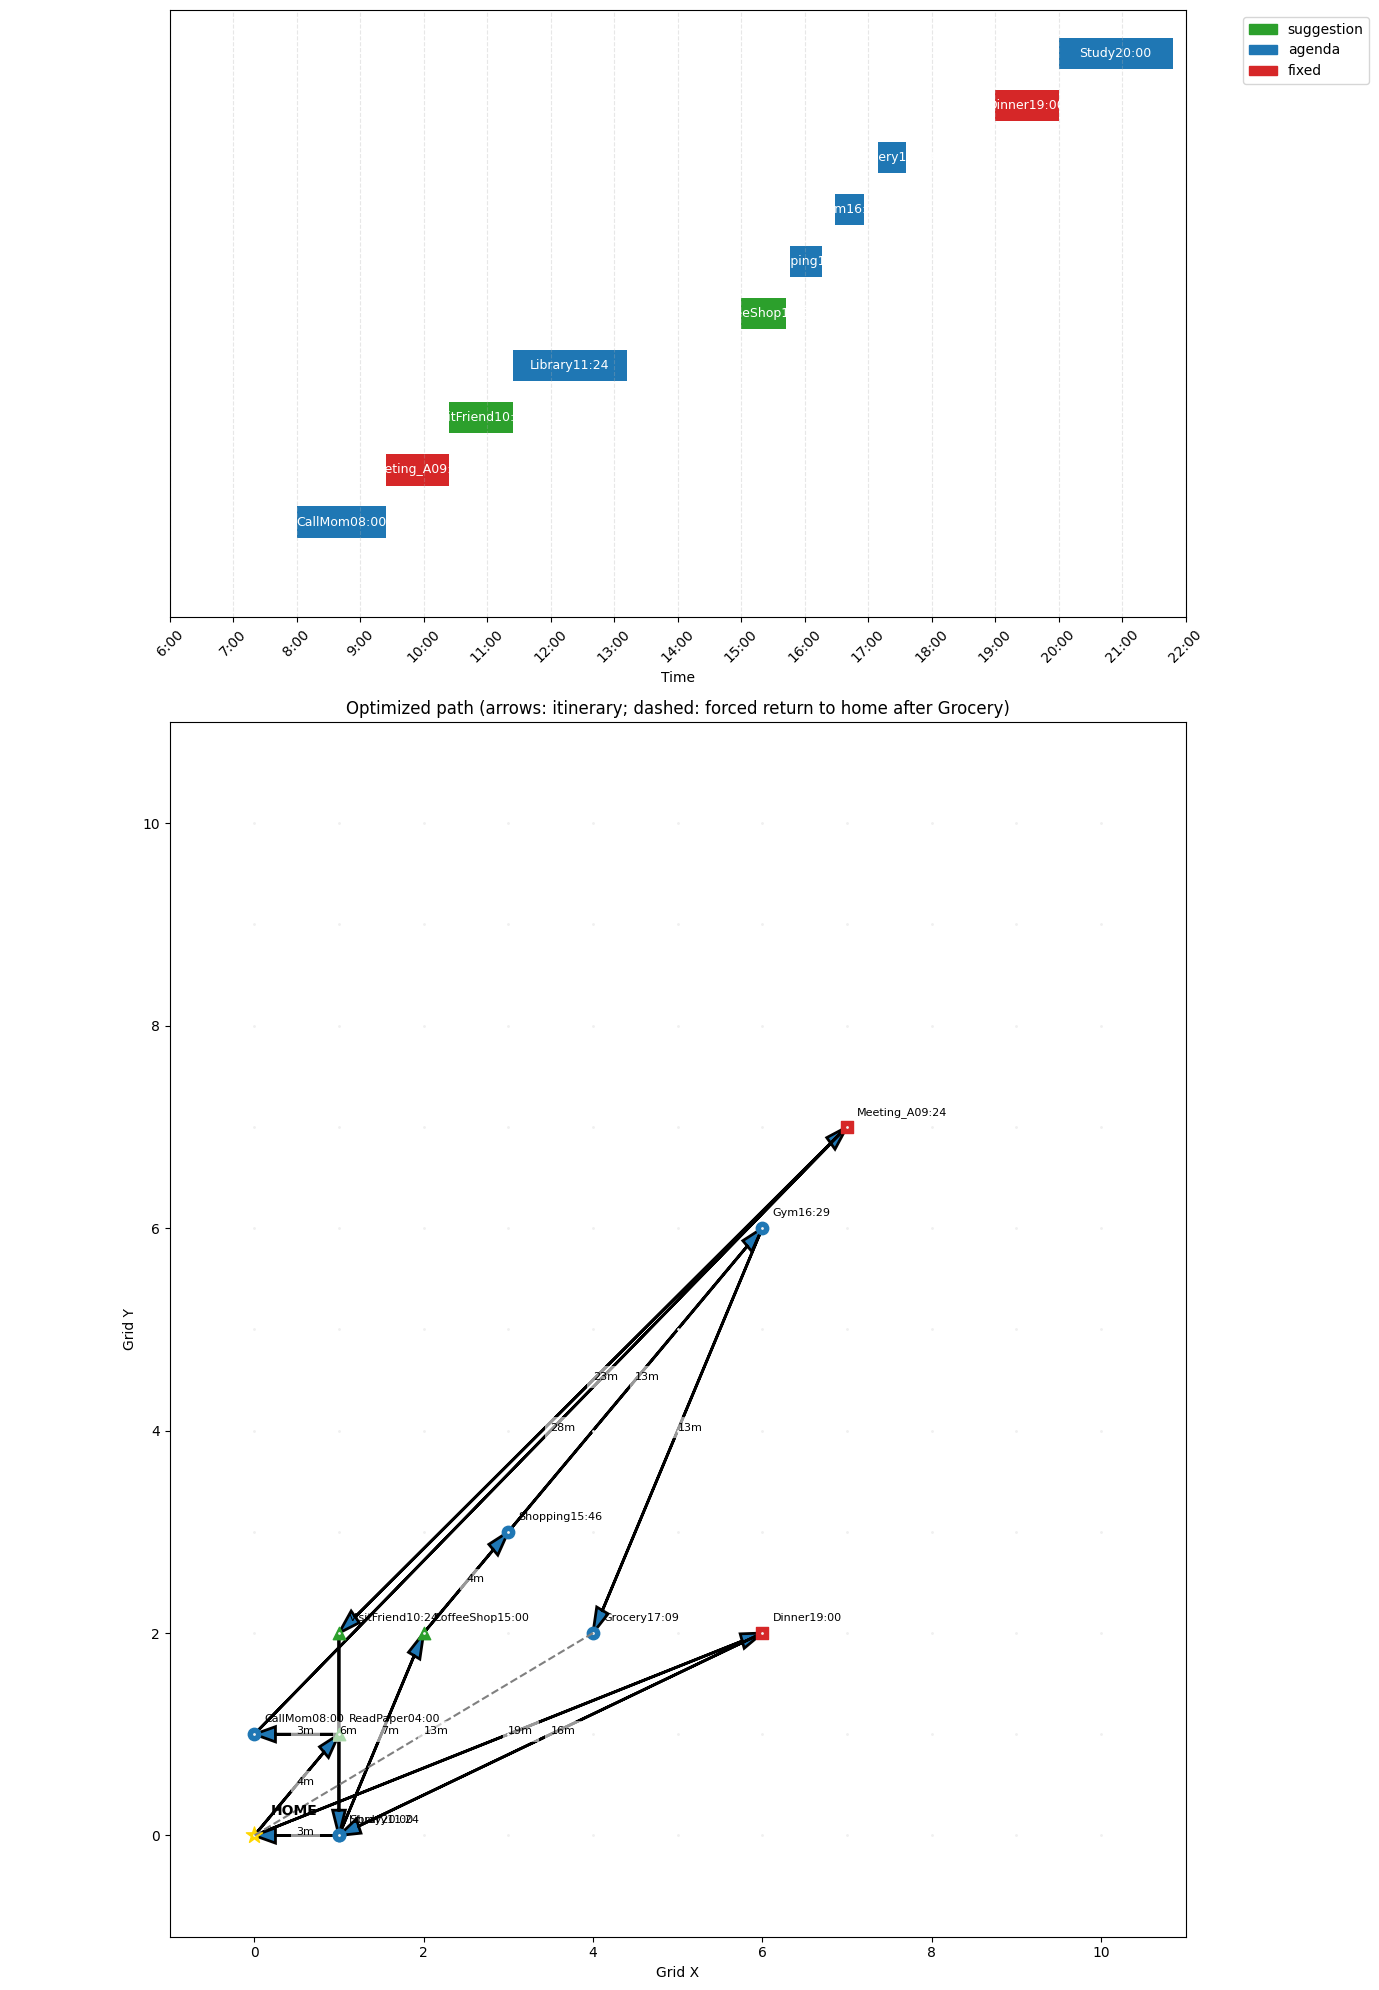

No overlaps detected in final schedule.


In [ ]:
# Force-directed Scheduler — Path-aware + Route Optimization (Improved Visualization, Event Types, No-overlap Guarantee)

'''
This Colab-ready notebook updates the previous version with the changes you asked for:

- **Clear path visualization**: arrows, travel-time labels, home marker, and dashed lines for returns after Grocery.
- **Event types**: each event now has `kind` in `{'fixed','agenda','suggestion'}` and the Gantt + map use distinct colors/markers to make them easy to distinguish.
- **No overlaps as a hard constraint**: final schedule is produced by route-optimization per bucket (`earliest_feasible_schedule_for_order`) which already enforces non-overlap. The notebook now runs only the route-optimization result for visualization and includes a final repair/assert to guarantee no overlaps. If an infeasible ordering is found, it reports which events conflict.

Run the notebook in Colab: paste this whole file into a Colab cell and run cells top-to-bottom.

---
'''
# %%
# Libraries
%matplotlib inline
import math, random, copy
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools

# %%
# Data structures (Event now has `kind`)
class EventVersion:
    def __init__(self, duration_min:int, coord:Tuple[int,int], pref_start_min:float, base_h:float, generated_by_llm:bool=False):
        self.duration = duration_min
        self.coord = coord
        self.pref_start = pref_start_min
        self.base_h = base_h
        self.generated_by_llm = generated_by_llm

class Event:
    def __init__(self, id:str, versions:List[EventVersion]=None, importance:float=0.5, motivation:float=0.5, fixed=False, fixed_start=None, fixed_coord=None, kind:str='agenda'):
        self.id = id
        self.versions = versions or []
        self.v = 0
        self.x = (self.versions[0].pref_start if self.versions else 8*60)
        self.importance = importance
        self.motivation = motivation
        self.fixed = fixed
        self.fixed_start = fixed_start
        self.fixed_coord = fixed_coord
        self.kind = kind  # 'fixed', 'agenda', 'suggestion'
    def current_version(self) -> EventVersion:
        return self.versions[self.v]

# %%
# Grid / travel (home=(0,0))
GRID_MIN, GRID_MAX = 0, 10
TRAVEL_SCALE = 3.0
HOME_COORD = (0,0)

def clamp_coord(coord):
    x,y = coord
    x = max(GRID_MIN, min(GRID_MAX, int(round(x))))
    y = max(GRID_MIN, min(GRID_MAX, int(round(y))))
    return (x,y)

def euclid(a:Tuple[int,int], b:Tuple[int,int]) -> float:
    return math.hypot(a[0]-b[0], a[1]-b[1])

def travel_time(coord1:Tuple[int,int], coord2:Tuple[int,int]) -> float:
    return TRAVEL_SCALE * euclid(coord1, coord2)

def minutes_to_hhmm(m:int) -> str:
    m = int(round(m))
    hh = (m//60) % 24
    mm = m % 60
    return f"{hh:02d}:{mm:02d}"

# %%
# Energy components (smaller constants for stability)
BETA = 50.0
GAMMA = 30.0
ALPHA_BASE = 3.0

def time_pref_factor(t_min:float) -> float:
    mu = 8*60
    sigma = 180.0
    rho = 0.7
    return 1.0 - rho * math.exp(-((t_min-mu)**2)/(2*sigma*sigma))

def access_factor(coord:Tuple[int,int]) -> float:
    d = euclid(coord, HOME_COORD)
    maxd = math.hypot(GRID_MAX-GRID_MIN, GRID_MAX-GRID_MIN)
    return 0.9 + (d/maxd) * 0.4

def hesitation_value(v:EventVersion, start_min:float) -> float:
    return v.base_h * time_pref_factor(start_min) * access_factor(v.coord)

def pref_energy(ev:Event) -> float:
    v = ev.current_version()
    mu = v.pref_start
    sigma = max(30.0, v.duration)
    alpha = ALPHA_BASE * (0.5 + ev.importance) * (0.4 + ev.motivation)
    return -alpha * math.exp(-((ev.x-mu)**2)/(2*sigma*sigma))

def overlap_energy(ev_i:Event, ev_j:Event) -> float:
    vi = ev_i.current_version(); vj = ev_j.current_version()
    a1,b1 = ev_i.x, ev_i.x + vi.duration
    a2,b2 = ev_j.x, ev_j.x + vj.duration
    inter = max(0.0, min(b1,b2) - max(a1,a2))
    return BETA * (inter**2)

def hesitation_energy(ev:Event) -> float:
    v = ev.current_version()
    h = hesitation_value(v, ev.x)
    return GAMMA * h

# %%
# Time window & auto-generation

def time_window_for_version(v:EventVersion, window_hours:float=3.0) -> Tuple[float,float]:
    a = max(0.0, v.pref_start - window_hours*60)
    b = min(24*60 - v.duration, v.pref_start + window_hours*60)
    return (a,b)


def generate_versions_for_event(base_duration:int, base_coord:Tuple[int,int], base_pref:int, base_h:float, n_versions:int=5):
    versions = []
    dur_muls = [0.6, 0.85, 1.0, 1.4, 1.8]
    pref_offsets = [-3*60, -60, 0, 60, 3*60]
    coord_offsets = [ (0,0), (1,0), (0,1), (-1,0), (0,-1) ]
    for i in range(n_versions):
        dur = max(10, int(round(base_duration * dur_muls[i])))
        pref = base_pref + pref_offsets[i]
        cand_coord = (base_coord[0] + coord_offsets[i][0], base_coord[1] + coord_offsets[i][1])
        cand_coord = clamp_coord(cand_coord)
        d_home = euclid(cand_coord, HOME_COORD)
        maxd = math.hypot(GRID_MAX-GRID_MIN, GRID_MAX-GRID_MIN)
        base_h_variant = min(0.95, max(0.05, base_h * (1.0 + 0.5*(d_home/maxd)) * (1.0 + 0.2*(dur/base_duration - 1.0))))
        v = EventVersion(duration_min=dur, coord=cand_coord, pref_start_min=pref, base_h=base_h_variant, generated_by_llm=True)
        versions.append(v)
    return versions


# --- Replace ensure_versions with this robust, randomized version ---
def ensure_versions(events:List[Event], seed:int = None):
    """
    Ensure each Event has versions. If base_duration/base_coord not provided, sample them.
    - seed: optional for reproducibility
    """
    if seed is not None:
        random.seed(seed)
    for ev in events:
        if ev.versions:
            # clamp coords if present
            for v in ev.versions:
                if v.coord is not None:
                    v.coord = clamp_coord(v.coord)
            if ev.fixed and ev.fixed_coord:
                ev.x = ev.fixed_start if ev.fixed_start is not None else ev.x
            continue

        # 1) determine base_duration (respect ev.base_duration if provided)
        if getattr(ev, 'base_duration', None) is not None:
            base_duration = int(ev.base_duration)
        else:
            # sample from a reasonable distribution (median ~60, more variance)
            # Clip to sensible bounds [15, 240] minutes and round to SLOT
            sampled = int(round(random.gauss(60, 30)))
            sampled = max(15, min(240, sampled))
            base_duration = round_to_slot_nearest(sampled, SLOT)

        # 2) determine base_coord (respect ev.fixed_coord if provided)
        if getattr(ev, 'fixed_coord', None) is not None:
            base_coord = clamp_coord(ev.fixed_coord)
        else:
            # If the user did not provide a base_coord, sample uniformly on grid,
            # but bias slightly toward HOME for higher importance events.
            imp = ev.importance if ev.importance is not None else 0.5
            # bias radius: more important -> closer to home
            max_r = int(max(1, (GRID_MAX - GRID_MIN) * (1.0 - 0.6*imp)))
            # sample polar-like offsets, then clamp
            dx = random.randint(-max_r, max_r)
            dy = random.randint(-max_r, max_r)
            cand = (HOME_COORD[0] + dx, HOME_COORD[1] + dy)
            base_coord = clamp_coord(cand)

        # 3) determine base_pref (preferred start) if not present -> random within day bounds
        # prefer distribution centered around mid-day but allow full range
        # sample via triangular between DAY_START..DAY_END to bias center
        base_pref_sample = int(random.triangular(DAY_START, DAY_END - base_duration, (DAY_START + DAY_END)//2))
        base_pref = round_to_slot_nearest(base_pref_sample, SLOT)

        # 4) base_h (hesitation) default random small value but scaled by distance & importance inside generator
        base_h = max(0.05, min(0.9, random.random() * (1.0 - ev.importance) + 0.05))

        # 5) generate versions using the generalized generator
        ev.versions = generate_versions_generalized(base_duration=base_duration,
                                                    base_coord=base_coord,
                                                    base_pref=base_pref,
                                                    base_h=base_h,
                                                    n_versions=K_VERSIONS,
                                                    kind=ev.kind,
                                                    importance=ev.importance,
                                                    slot=SLOT)
        # 6) initial x set to preferred of chosen version (rounded)
        ev.x = max(DAY_START, min(DAY_END - ev.current_version().duration, round_to_slot_nearest(ev.versions[0].pref_start, SLOT)))

def earliest_feasible_schedule_for_order(order:List[Event]) -> Tuple[bool, List[float], float]:
    n = len(order)
    start_times = [0.0]*n
    first = order[0]
    v0 = first.current_version()
    tw0 = time_window_for_version(v0)
    t0 = max(tw0[0], travel_time(HOME_COORD, v0.coord))
    start_times[0] = t0
    if start_times[0] > tw0[1]:
        return False, [], float('inf')
    for i in range(1,n):
        prev = order[i-1]; cur = order[i]
        prev_v = prev.current_version(); cur_v = cur.current_version()
        if 'grocery' in prev.id.lower():
            travel = travel_time(prev_v.coord, HOME_COORD) + travel_time(HOME_COORD, cur_v.coord)
            earliest = start_times[i-1] + prev_v.duration + travel
        else:
            travel = travel_time(prev_v.coord, cur_v.coord)
            earliest = start_times[i-1] + prev_v.duration + travel
        tw = time_window_for_version(cur_v)
        st = max(tw[0], earliest)
        if st > tw[1]:
            return False, [], float('inf')
        start_times[i] = st
    total_travel = travel_time(HOME_COORD, order[0].current_version().coord)
    for i in range(len(order)-1):
        cur = order[i].current_version(); nxt = order[i+1].current_version()
        if 'grocery' in order[i].id.lower():
            total_travel += travel_time(cur.coord, HOME_COORD) + travel_time(HOME_COORD, nxt.coord)
        else:
            total_travel += travel_time(cur.coord, nxt.coord)
    total_travel += travel_time(order[-1].current_version().coord, HOME_COORD)
    return True, start_times, total_travel

# evaluate cost + optimizers unchanged

def evaluate_order_cost(order:List[Event], weight_time_dev:float=1.0, weight_travel:float=1.0) -> Tuple[float, bool, List[float]]:
    feasible, start_times, total_travel = earliest_feasible_schedule_for_order(order)
    if not feasible:
        return float('inf'), False, []
    dev = 0.0
    for ev, st in zip(order, start_times):
        pref = ev.current_version().pref_start
        dev += ((st - pref)/60.0)**2
    cost = weight_time_dev * dev + weight_travel * total_travel
    return cost, True, start_times


def optimize_order_bruteforce(events_bucket:List[Event], max_bruteforce=8):
    n = len(events_bucket)
    if n == 0:
        return [], [], 0.0
    if n <= max_bruteforce:
        best_cost = float('inf'); best_order=None; best_starts=None; best_travel=0.0
        for perm in itertools.permutations(events_bucket):
            cost, feas, starts = evaluate_order_cost(list(perm))
            if feas and cost < best_cost:
                best_cost = cost; best_order = list(perm); best_starts = starts
        if best_order is None:
            return [], [], float('inf')
        _,_,travel = earliest_feasible_schedule_for_order(best_order)
        return best_order, best_starts, travel
    else:
        order = nearest_neighbor_order(events_bucket)
        order = two_opt_improve(order)
        feasible, starts, travel = earliest_feasible_schedule_for_order(order)
        if not feasible:
            order = events_bucket
            feasible, starts, travel = earliest_feasible_schedule_for_order(order)
        return order, starts, travel

# nearest & 2-opt

def nearest_neighbor_order(events_bucket:List[Event]) -> List[Event]:
    if not events_bucket:
        return []
    remaining = events_bucket.copy()
    remaining.sort(key=lambda e: travel_time(HOME_COORD, e.current_version().coord))
    cur = remaining.pop(0)
    order = [cur]
    while remaining:
        prev = order[-1]
        if 'grocery' in prev.id.lower():
            remaining.sort(key=lambda e: travel_time(HOME_COORD, e.current_version().coord))
            nxt = remaining.pop(0)
            order.append(nxt)
        else:
            remaining.sort(key=lambda e: travel_time(prev.current_version().coord, e.current_version().coord))
            nxt = remaining.pop(0)
            order.append(nxt)
    return order


def two_opt_improve(order:List[Event], max_iter=200):
    if len(order) < 4:
        return order
    best = order.copy()
    improved = True
    it = 0
    while improved and it < max_iter:
        improved = False
        it += 1
        for i in range(1, len(best)-2):
            for j in range(i+1, len(best)-1):
                new_order = best[:i] + list(reversed(best[i:j+1])) + best[j+1:]
                cost_new, feas, _ = evaluate_order_cost(new_order)
                cost_old, feas_old, _ = evaluate_order_cost(best)
                if feas and cost_new < cost_old:
                    best = new_order
                    improved = True
                    break
            if improved:
                break
    return best

# %%
# Stable softmax selection + gradient primitives

def split_by_fixed_events(events:List[Event]) -> List[Tuple[List[Event], Event, Event]]:
    fixed_sorted = sorted([e for e in events if e.fixed], key=lambda e: e.fixed_start)
    buckets = []
    nonfixed = [e for e in events if not e.fixed]
    boundaries = [0.0]
    for fe in fixed_sorted:
        boundaries.append(fe.fixed_start)
    boundaries.append(24*60)
    for i in range(len(boundaries)-1):
        a,b = boundaries[i], boundaries[i+1]
        bucket = [e for e in nonfixed if e.x >= a and e.x < b]
        prev_fixed = None if i==0 else fixed_sorted[i-1]
        next_fixed = None if i==len(boundaries)-2 else fixed_sorted[i]
        buckets.append((bucket, prev_fixed, next_fixed))
    return buckets


def numeric_gradient(events: List[Event], eps: float = 0.5) -> Dict[str, float]:
    grads = {}
    def energy_local():
        E = 0.0
        for ev in events:
            E += pref_energy(ev) + hesitation_energy(ev)
        for i, ev_i in enumerate(events):
            for j, ev_j in enumerate(events):
                if i < j:
                    E += overlap_energy(ev_i, ev_j)
        return E
    base_E = energy_local()
    for ev in events:
        if ev.fixed:
            grads[ev.id] = 0.0
            continue
        orig_x = ev.x
        ev.x = orig_x + eps
        Ep = energy_local()
        grad = (Ep - base_E) / eps
        grads[ev.id] = grad
        ev.x = orig_x
    return grads


def apply_position_update(events: List[Event], grads: Dict[str, float], eta: float = 0.4):
    for ev in events:
        if ev.fixed:
            if ev.fixed_start is not None:
                ev.x = ev.fixed_start
            continue
        v = ev.current_version()
        tw0, tw1 = time_window_for_version(v)
        new_x = ev.x - eta * grads.get(ev.id, 0.0)
        ev.x = max(tw0, min(tw1, new_x))


def softmax_select_version(ev: Event, all_events: List[Event], temp: float = 1.0):
    if ev.fixed or not ev.versions:
        return
    energies = []
    orig_v = ev.v
    orig_x = ev.x
    for vidx, v in enumerate(ev.versions):
        ev.v = vidx
        ev.x = v.pref_start
        E_loc = pref_energy(ev) + hesitation_energy(ev)
        for other in all_events:
            if other.id == ev.id:
                continue
            E_loc += overlap_energy(ev, other)
        energies.append(E_loc)
    ev.v = orig_v
    ev.x = orig_x
    temp_safe = max(1e-6, temp)
    logits = [ -e / temp_safe for e in energies ]
    m = max(logits)
    shifted = [l - m for l in logits]
    exp_vals = [math.exp(s) for s in shifted]
    s = sum(exp_vals)
    if s == 0.0:
        probs = [1.0/len(exp_vals)] * len(exp_vals)
    else:
        probs = [v/s for v in exp_vals]
    chosen = random.choices(range(len(ev.versions)), weights=probs, k=1)[0]
    ev.v = chosen
    ev.x = ev.current_version().pref_start

# %%
# Optimization pipeline: initial relax + per-bucket route optimization

def optimize_schedule_with_routes(events:List[Event]):
    events = copy.deepcopy(events)
    ensure_versions(events)
    for _ in range(60):
        grads = numeric_gradient(events, eps=0.5)
        apply_position_update(events, grads, eta=0.4)
        for ev in events:
            softmax_select_version(ev, events, temp=0.7)
    buckets = split_by_fixed_events(events)
    for bucket, prev_fixed, next_fixed in buckets:
        if not bucket:
            continue
        order, starts, travel = optimize_order_bruteforce(bucket, max_bruteforce=8)
        if not order:
            order = sorted(bucket, key=lambda e: e.x)
            feasible, starts, travel = earliest_feasible_schedule_for_order(order)
        # assign
        for ev, st in zip(order, starts):
            for e in events:
                if e.id == ev.id:
                    e.v = ev.v
                    e.x = st
                    break
    # Final repair: assert no overlaps anywhere; if overlaps exist, push conflicting agenda/suggestion forward inside their time windows
    events_sorted = sorted(events, key=lambda e: e.x)
    for i in range(1,len(events_sorted)):
        prev = events_sorted[i-1]; cur = events_sorted[i]
        prev_end = prev.x + prev.current_version().duration
        if cur.x < prev_end:
            # try to shift cur forward to prev_end, respecting its time window
            tw0, tw1 = time_window_for_version(cur.current_version())
            new_start = prev_end
            if new_start + cur.current_version().duration <= tw1:
                cur.x = new_start
            else:
                # Can't repair: report conflict (could implement backtracking / reorder)
                print(f"UNRESOLVED OVERLAP between {prev.id} and {cur.id}")
    return events

# %%
# Sample generation with explicit kinds and run

def sample_events_more():
    events = []
    E1 = Event('Meeting_A', versions=[EventVersion(60,(7,7),9*60,0.05,generated_by_llm=False)], importance=0.9, motivation=0.8, fixed=True, fixed_start=9*60, fixed_coord=(7,7), kind='fixed')
    events.append(E1)
    # create several agenda events
    events.append(Event('Grocery', versions=None, importance=0.4, motivation=0.5, kind='agenda'))
    events.append(Event('Study', versions=None, importance=0.85, motivation=0.9, kind='agenda'))
    events.append(Event('Gym', versions=None, importance=0.6, motivation=0.7, kind='agenda'))
    # suggestions (not urgent)
    events.append(Event('ReadPaper', versions=None, importance=0.5, motivation=0.3, kind='suggestion'))
    events.append(Event('CoffeeShop', versions=None, importance=0.4, motivation=0.4, kind='suggestion'))
    events.append(Event('CallMom', versions=None, importance=0.9, motivation=0.9, kind='agenda'))
    events.append(Event('Library', versions=None, importance=0.6, motivation=0.5, kind='agenda'))
    events.append(Event('Shopping', versions=None, importance=0.3, motivation=0.4, kind='agenda'))
    events.append(Event('VisitFriend', versions=None, importance=0.3, motivation=0.5, kind='suggestion'))
    E_end = Event('Dinner', versions=[EventVersion(60,(6,2),19*60,0.1,generated_by_llm=False)], importance=0.8, motivation=0.7, fixed=True, fixed_start=19*60, fixed_coord=(6,2), kind='fixed')
    events.append(E_end)
    ensure_versions(events)
    for ev in events:
        ev.x = ev.current_version().pref_start
    return events

random.seed(7)
events = sample_events_more()
print("Initial events generated (id, kind, pref, dur, coord):")
for ev in events:
    v = ev.current_version()
    print(f"{ev.id:12s} {ev.kind:10s} pref={minutes_to_hhmm(v.pref_start)} dur={v.duration} coord={v.coord}")

optimized_events = optimize_schedule_with_routes(events)
print("Optimization complete.")

# %%
# Visualization: color by kind, show path arrows and travel times

def build_path_order(events:List[Event]):
    seq = sorted(events, key=lambda e: e.x)
    path = [HOME_COORD]
    times = [None]
    segments = []  # list of (from, to, travel_mins, dashed_flag)
    for i, ev in enumerate(seq):
        v = ev.current_version()
        prev = path[-1]
        # if prev is HOME and this event is first, we have home->event
        # handle grocery special: after grocery we add a HOME arrival segment
        # record segment
        segments.append((prev, v.coord, travel_time(prev, v.coord), False))
        path.append(v.coord)
        times.append(ev.x)
        if 'grocery' in ev.id.lower():
            segments.append((v.coord, HOME_COORD, travel_time(v.coord, HOME_COORD), True))
            path.append(HOME_COORD)
            times.append(ev.x + v.duration + travel_time(v.coord, HOME_COORD))
    # final return to home if last not home
    if path[-1] != HOME_COORD:
        segments.append((path[-1], HOME_COORD, travel_time(path[-1], HOME_COORD), False))
        path.append(HOME_COORD); times.append(None)
    return seq, path, times, segments

KIND_COLORS = {'fixed':'#d62728','agenda':'#1f77b4','suggestion':'#2ca02c'}
KIND_MARKERS = {'fixed':'s','agenda':'o','suggestion':'^'}


def plot_results(events:List[Event]):
    seq, path, times, segments = build_path_order(events)
    fig, axes = plt.subplots(2,1, figsize=(14,20), gridspec_kw={'height_ratios':[1,2]})
    ax = axes[0]
    y = 0
    legend_handles = {}
    for idx, ev in enumerate(sorted(events, key=lambda e: e.x)):
        v = ev.current_version()
        start = ev.x
        dur = v.duration
        color = KIND_COLORS.get(ev.kind, '#888888')
        ax.barh(y, dur, left=start, height=0.6, align='center', color=color)
        ax.text(start + dur/2, y, f"{ev.id}{minutes_to_hhmm(start)}", va='center', ha='center', color='white', fontsize=9)
        if ev.kind not in legend_handles:
            legend_handles[ev.kind] = mpatches.Patch(color=color, label=f"{ev.kind}")
        y += 1
    ax.set_xlabel('Time')
    ax.set_yticks([])
    ax.set_xlim(6*60, 22*60)
    ax.set_xticks([h*60 for h in range(6,23)])
    ax.set_xticklabels([f"{h}:00" for h in range(6,23)], rotation=45)
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.legend(handles=list(legend_handles.values()), bbox_to_anchor=(1.05,1), loc='upper left')

    ax2 = axes[1]
    for xi in range(GRID_MIN, GRID_MAX+1):
        for yi in range(GRID_MIN, GRID_MAX+1):
            ax2.plot(xi, yi, marker='.', color='#f0f0f0', markersize=2)
    # draw segments with arrows and travel labels
    for (a,b,tm,dashed) in segments:
        xs = [a[0], b[0]]; ys=[a[1], b[1]]
        if dashed:
            ax2.plot(xs, ys, '--', linewidth=1.5, color='gray')
        else:
            ax2.arrow(xs[0], ys[0], xs[1]-xs[0], ys[1]-ys[0], length_includes_head=True, head_width=0.15, head_length=0.25, linewidth=2)
        # label travel time at midpoint
        mx = (xs[0]+xs[1])/2; my=(ys[0]+ys[1])/2
        ax2.text(mx, my, f"{tm:.0f}m", fontsize=8, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    # plot points with kind markers
    for ev in seq:
        v = ev.current_version()
        c = KIND_COLORS.get(ev.kind, '#444444')
        m = KIND_MARKERS.get(ev.kind, 'o')
        ax2.scatter(v.coord[0], v.coord[1], color=c, marker=m, s=80)
        ax2.text(v.coord[0]+0.12, v.coord[1]+0.12, f"{ev.id}{minutes_to_hhmm(ev.x)}", fontsize=8)
    # home
    ax2.scatter(HOME_COORD[0], HOME_COORD[1], marker='*', s=150, color='gold')
    ax2.text(HOME_COORD[0]+0.2, HOME_COORD[1]+0.2, 'HOME', fontsize=10, fontweight='bold')
    ax2.set_xlim(GRID_MIN-1, GRID_MAX+1); ax2.set_ylim(GRID_MIN-1, GRID_MAX+1)
    ax2.set_title('Optimized path (arrows: itinerary; dashed: forced return to home after Grocery)')
    ax2.set_xlabel('Grid X'); ax2.set_ylabel('Grid Y')
    plt.tight_layout()
    return fig

fig = plot_results(optimized_events)
plt.show()

# %%
# Final check: assert no overlaps

def check_no_overlaps(events:List[Event]):
    seq = sorted(events, key=lambda e: e.x)
    problems = []
    for i in range(1,len(seq)):
        prev = seq[i-1]; cur = seq[i]
        prev_end = prev.x + prev.current_version().duration
        if cur.x < prev_end - 1e-6:
            problems.append((prev.id, cur.id, prev_end, cur.x))
    return problems

probs = check_no_overlaps(optimized_events)
if probs:
    print('Overlap problems detected:')
    for p in probs:
        print(p)
else:
    print('No overlaps detected in final schedule.')

# %%
# Notes / next steps
# - The visualization now clearly distinguishes kinds and shows the path with travel-time labels.
# - Final schedule is produced by route-based ordering which enforces no-overlap; a repair pass is included.
# - Next: integrate real map travel times (OSRM/Google) or OR-Tools time-window VRP for larger buckets.


# Ultimate Scalable Scheduler - Production Ready
"""
Ultimate Scheduler: Combines OR-Tools VRPTW with sophisticated version generation,
intelligent suggestion scoring, and enhanced visualization.

Key features:
- 10-minute slot quantization for stability
- Strict day bounds (7am-10pm)
- OR-Tools VRPTW for robust optimization
- Sophisticated version generation with parameterized control
- Intelligent suggestion scoring and selection
- Enhanced visualization with clear paths and metrics
- Multiple fallback strategies for robustness
"""

# %% Install dependencies (run once in Colab)
!pip install -q ortools

# %% Imports
import math
import random
import copy
from typing import List, Tuple, Dict, Optional, Set
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
import numpy as np
from datetime import datetime, timedelta
import itertools
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

# %% Configuration and Constants
@dataclass
class SchedulerConfig:
    """Central configuration for the scheduler"""
    # Time configuration
    SLOT_MINUTES: int = 10          # 10-minute slots
    DAY_START: int = 7 * 60         # 7:00 AM
    DAY_END: int = 22 * 60          # 10:00 PM

    # Grid configuration
    GRID_MIN: int = 0
    GRID_MAX: int = 10
    HOME_COORD: Tuple[int, int] = (0, 0)
    TRAVEL_SCALE: float = 3.0       # minutes per grid unit

    # Version generation parameters
    F_MIN: float = 0.6              # Min duration factor
    F_MAX: float = 1.8              # Max duration factor
    K_VERSIONS: int = 5             # Number of versions to generate
    DELTA_ABS_CAP: int = 180        # Max time offset (minutes)
    KAPPA_TIME: float = 0.5         # Time offset proportionality
    R0: float = 0.8                 # Base radius for location variation
    RHO_RADIUS: float = 1.2         # Radius scaling with duration
    P_LOCLESS_BASE: float = 0.35    # Base probability of locationless
    ALPHA_H: float = 0.6            # Hesitation scaling by distance
    BETA_H: float = 0.8             # Hesitation scaling by duration

    # Optimization parameters
    OR_TOOLS_TIME_LIMIT: int = 10   # Seconds per bucket
    SUGGESTION_ALPHA: float = 0.05   # Cost weighting for suggestions
    TAU_DURATION: float = 60.0       # Duration fit decay
    TAU_TIME: float = 180.0          # Time preference decay

    # Visualization
    COLORS: Dict[str, str] = field(default_factory=lambda: {
        'fixed': '#d62728',
        'agenda': '#1f77b4',
        'suggestion': '#2ca02c'
    })
    MARKERS: Dict[str, str] = field(default_factory=lambda: {
        'fixed': 's',
        'agenda': 'o',
        'suggestion': '^'
    })

# Global config instance
CONFIG = SchedulerConfig()

# %% Data Classes
@dataclass
class EventVersion:
    """Represents a possible version of an event"""
    duration: int  # minutes
    coord: Optional[Tuple[int, int]]
    pref_start: float  # preferred start time
    base_h: float  # hesitation value
    generated_by_llm: bool = False
    confidence: float = 1.0  # confidence in this version

@dataclass
class Event:
    """Represents a schedulable event"""
    id: str
    kind: str  # 'fixed', 'agenda', 'suggestion'
    versions: List[EventVersion] = field(default_factory=list)
    importance: float = 0.5
    motivation: float = 0.5
    fixed: bool = False
    fixed_start: Optional[int] = None
    fixed_coord: Optional[Tuple[int, int]] = None
    base_duration: Optional[float] = None
    base_coord: Optional[Tuple[int, int]] = None
    dependencies: Set[str] = field(default_factory=set)  # event IDs this depends on

    # Runtime state
    v: int = 0  # selected version index
    x: float = 0  # scheduled start time

    def __post_init__(self):
        if self.versions:
            self.x = self.versions[0].pref_start
        else:
            self.x = CONFIG.DAY_START + 60  # Default to 8am

    def current_version(self) -> EventVersion:
        return self.versions[self.v] if self.versions else None

# %% Utility Functions
def clamp_coord(coord: Optional[Tuple[int, int]]) -> Optional[Tuple[int, int]]:
    """Clamp coordinates to grid bounds"""
    if coord is None:
        return None
    x, y = coord
    x = max(CONFIG.GRID_MIN, min(CONFIG.GRID_MAX, int(round(x))))
    y = max(CONFIG.GRID_MIN, min(CONFIG.GRID_MAX, int(round(y))))
    return (x, y)

def euclid(a: Tuple[int, int], b: Tuple[int, int]) -> float:
    """Euclidean distance between two points"""
    return math.hypot(a[0] - b[0], a[1] - b[1])

def travel_time(coord1: Optional[Tuple[int, int]],
                coord2: Optional[Tuple[int, int]]) -> float:
    """Calculate travel time between coordinates"""
    c1 = coord1 if coord1 is not None else CONFIG.HOME_COORD
    c2 = coord2 if coord2 is not None else CONFIG.HOME_COORD
    return CONFIG.TRAVEL_SCALE * euclid(c1, c2)

def round_to_slot(minutes: float, mode: str = 'nearest') -> int:
    """Round time to slot boundary"""
    if mode == 'up':
        return int(math.ceil(minutes / CONFIG.SLOT_MINUTES) * CONFIG.SLOT_MINUTES)
    elif mode == 'down':
        return int(math.floor(minutes / CONFIG.SLOT_MINUTES) * CONFIG.SLOT_MINUTES)
    else:  # nearest
        return int(round(minutes / CONFIG.SLOT_MINUTES) * CONFIG.SLOT_MINUTES)

def minutes_to_hhmm(m: int) -> str:
    """Convert minutes to HH:MM format"""
    m = int(round(m))
    hh = (m // 60) % 24
    mm = m % 60
    return f"{hh:02d}:{mm:02d}"

def time_window_for_version(v: EventVersion,
                           window_hours: float = 3.0) -> Tuple[int, int]:
    """Get valid time window for an event version"""
    a = max(CONFIG.DAY_START, int(v.pref_start - window_hours * 60))
    b = min(CONFIG.DAY_END - v.duration, int(v.pref_start + window_hours * 60))
    a = round_to_slot(a)
    b = max(a, round_to_slot(b))
    b = min(b, CONFIG.DAY_END - v.duration)
    a = min(a, b)
    return (a, b)

# %% Advanced Version Generation
def logspace_factors(k: int, fmin: float, fmax: float) -> List[float]:
    """Generate k factors in log space between fmin and fmax"""
    if k == 1:
        return [1.0]
    logmin, logmax = math.log(fmin), math.log(fmax)
    return [math.exp(logmin + i * (logmax - logmin) / (k - 1)) for i in range(k)]

def generate_versions_advanced(
    base_duration: float,
    base_coord: Optional[Tuple[int, int]],
    base_pref: float,
    base_h: float = 0.3,
    n_versions: int = CONFIG.K_VERSIONS,
    kind: str = 'agenda',
    importance: float = 0.5
) -> List[EventVersion]:
    """
    Generate event versions with sophisticated variation strategies
    """
    if base_duration is None or base_duration <= 0:
        base_duration = 60

    factors = logspace_factors(n_versions, CONFIG.F_MIN, CONFIG.F_MAX)
    versions = []
    maxd_grid = math.hypot(CONFIG.GRID_MAX - CONFIG.GRID_MIN,
                          CONFIG.GRID_MAX - CONFIG.GRID_MIN)

    for idx, f in enumerate(factors):
        # Duration variation
        dur_raw = max(1, int(round(base_duration * f)))
        dur = max(CONFIG.SLOT_MINUTES, round_to_slot(dur_raw))

        # Time offset variation
        delta_max = min(CONFIG.DELTA_ABS_CAP, int(CONFIG.KAPPA_TIME * dur))
        if n_versions == 1:
            offset = 0
        else:
            pos = idx / (n_versions - 1)
            offset = int((pos - 0.5) * 2 * delta_max)

        pref = base_pref + offset
        pref = max(CONFIG.DAY_START, min(CONFIG.DAY_END - dur, pref))
        pref = round_to_slot(pref)

        # Location variation
        coord_use = base_coord
        if kind in ('agenda', 'suggestion') and base_coord is not None:
            # Probability of locationless increases for less important suggestions
            p_locless = CONFIG.P_LOCLESS_BASE * (1.0 - importance)

            if random.random() < p_locless:
                coord_use = None
            else:
                # Spatial variation with smart radius
                dur_ratio = dur / max(1, base_duration)
                radius = CONFIG.R0 + CONFIG.RHO_RADIUS * max(0.0, (dur_ratio - 1.0))

                # Gaussian-distributed offset for more natural clustering
                theta = random.random() * 2 * math.pi
                rad = random.gauss(0, radius / 2)
                rad = max(0, min(radius, abs(rad)))

                dx = int(round(rad * math.cos(theta)))
                dy = int(round(rad * math.sin(theta)))
                cand = (base_coord[0] + dx, base_coord[1] + dy)
                coord_use = clamp_coord(cand)

        # Hesitation value with context awareness
        d_home = 0.0 if coord_use is None else euclid(coord_use, CONFIG.HOME_COORD)
        h_variant = base_h * (1.0 +
                             CONFIG.ALPHA_H * (d_home / maxd_grid) +
                             CONFIG.BETA_H * abs(f - 1.0))
        h_variant = max(0.05, min(0.95, h_variant))

        # Confidence based on deviation from base
        confidence = math.exp(-abs(f - 1.0) / 2.0)

        v = EventVersion(
            duration=dur,
            coord=coord_use,
            pref_start=pref,
            base_h=h_variant,
            generated_by_llm=True,
            confidence=confidence
        )
        versions.append(v)

    return versions

# %% Event Initialization
def ensure_versions(events: List[Event]) -> None:
    """Ensure all events have versions, generating if needed"""
    for ev in events:
        if ev.versions:
            # Validate existing versions
            for v in ev.versions:
                if v.coord is not None:
                    v.coord = clamp_coord(v.coord)
            if ev.fixed and ev.fixed_start is not None:
                ev.x = ev.fixed_start
            continue

        # Determine base parameters
        base_duration = ev.base_duration if ev.base_duration else 60
        base_coord = ev.base_coord if ev.base_coord else (
            random.randint(CONFIG.GRID_MIN + 1, CONFIG.GRID_MAX - 1),
            random.randint(CONFIG.GRID_MIN + 1, CONFIG.GRID_MAX - 1)
        )

        # Smart preference heuristics based on event name
        name_lower = ev.id.lower()
        if 'morning' in name_lower or 'breakfast' in name_lower:
            base_pref = 8 * 60
        elif 'lunch' in name_lower:
            base_pref = 12 * 60
        elif 'dinner' in name_lower or 'evening' in name_lower:
            base_pref = 19 * 60
        elif 'gym' in name_lower or 'workout' in name_lower:
            base_pref = 18 * 60
        elif 'meeting' in name_lower or 'work' in name_lower:
            base_pref = 10 * 60
        else:
            # Distribute throughout the day
            base_pref = CONFIG.DAY_START + (CONFIG.DAY_END - CONFIG.DAY_START) * 0.4

        base_h = 0.3 * (1.0 - ev.importance)

        ev.versions = generate_versions_advanced(
            base_duration=base_duration,
            base_coord=base_coord,
            base_pref=base_pref,
            base_h=base_h,
            n_versions=CONFIG.K_VERSIONS,
            kind=ev.kind,
            importance=ev.importance
        )

        if ev.versions:
            ev.x = max(CONFIG.DAY_START,
                      min(CONFIG.DAY_END - ev.versions[0].duration,
                          round_to_slot(ev.versions[0].pref_start)))

# %% Scoring Functions
def suggestion_score(ev: Event, ver: EventVersion) -> Tuple[float, float, float]:
    """
    Score a suggestion event version based on benefit vs cost
    Returns: (score, benefit, estimated_cost)
    """
    # Benefit components
    importance = ev.importance * ev.motivation

    # Duration fit
    dstar = ev.base_duration if ev.base_duration else 60
    duration_fit = math.exp(-abs(ver.duration - dstar) / CONFIG.TAU_DURATION)

    # Time preference fit
    mu_user = 12 * 60  # Midday preference
    time_fit = math.exp(-abs(ver.pref_start - mu_user) / CONFIG.TAU_TIME)

    # Confidence weighting
    confidence_weight = ver.confidence if hasattr(ver, 'confidence') else 1.0

    benefit = importance * duration_fit * time_fit * confidence_weight

    # Cost estimation
    est_travel = round_to_slot(travel_time(CONFIG.HOME_COORD, ver.coord), 'up') if ver.coord else 0
    est_cost = est_travel + ver.duration

    # Final score with diminishing returns
    score = benefit / (1.0 + CONFIG.SUGGESTION_ALPHA * est_cost)

    return score, benefit, est_cost

# %% OR-Tools VRPTW Solver
def solve_bucket_with_ortools(
    bucket: List[Event],
    time_limit_seconds: int = CONFIG.OR_TOOLS_TIME_LIMIT
) -> Tuple[Optional[List[Event]], Optional[List[int]]]:
    """
    Solve scheduling for a bucket using OR-Tools VRPTW
    Returns: (ordered_events, start_times) or (None, None) if infeasible
    """
    if not bucket:
        return [], []

    # Build nodes: 0 = depot (home)
    locations = [CONFIG.HOME_COORD]
    service_times = [0]
    time_windows = [(CONFIG.DAY_START, CONFIG.DAY_END)]

    for ev in bucket:
        v = ev.current_version()
        loc = v.coord if v.coord is not None else CONFIG.HOME_COORD
        locations.append(loc)
        service_times.append(int(v.duration))

        tw = time_window_for_version(v)
        tw0 = int(max(CONFIG.DAY_START, min(CONFIG.DAY_END - v.duration, tw[0])))
        tw1 = int(max(CONFIG.DAY_START, min(CONFIG.DAY_END - v.duration, tw[1])))
        if tw0 > tw1:
            tw0 = tw1 = max(CONFIG.DAY_START, min(CONFIG.DAY_END - v.duration, tw1))
        time_windows.append((tw0, tw1))

    n_nodes = len(locations)

    # Build travel matrix with special handling
    travel_matrix = [[0] * n_nodes for _ in range(n_nodes)]
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i == j:
                travel_matrix[i][j] = 0
            else:
                coord_i, coord_j = locations[i], locations[j]
                base = travel_time(coord_i, coord_j)

                # Special case: grocery requires return home
                if i > 0 and 'grocery' in bucket[i-1].id.lower() and j != 0:
                    base = travel_time(coord_i, CONFIG.HOME_COORD) + \
                           travel_time(CONFIG.HOME_COORD, coord_j)

                travel_matrix[i][j] = int(round_to_slot(base, 'up'))

    # Create routing model
    horizon = CONFIG.DAY_END - CONFIG.DAY_START

    # Shift time windows to zero-based
    shifted_windows = []
    for (lo, hi) in time_windows:
        slo = max(0, min(horizon, lo - CONFIG.DAY_START))
        shi = max(0, min(horizon, hi - CONFIG.DAY_START))
        if slo > shi:
            slo = shi = max(0, min(horizon, shi))
        shifted_windows.append((slo, shi))

    try:
        manager = pywrapcp.RoutingIndexManager(n_nodes, 1, 0)
        routing = pywrapcp.RoutingModel(manager)

        # Transit callback
        def transit_cb(from_index, to_index):
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return travel_matrix[from_node][to_node] + service_times[from_node]

        transit_index = routing.RegisterTransitCallback(transit_cb)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_index)

        # Add time dimension
        routing.AddDimension(
            transit_index,
            horizon,  # slack
            horizon,  # capacity
            True,     # fix_start_cumul_to_zero
            'Time'
        )
        time_dimension = routing.GetDimensionOrDie('Time')

        # Set time windows
        for node in range(n_nodes):
            idx = manager.NodeToIndex(node)
            slo, shi = shifted_windows[node]

            if node == 0:  # Depot
                time_dimension.CumulVar(idx).SetRange(0, 0)
            else:
                time_dimension.CumulVar(idx).SetRange(slo, shi)

        # Search parameters
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = \
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        search_parameters.local_search_metaheuristic = \
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
        search_parameters.time_limit.seconds = time_limit_seconds
        search_parameters.log_search = False

        # Solve
        sol = routing.SolveWithParameters(search_parameters)

        if sol is None:
            return None, None

        # Extract solution
        index = routing.Start(0)
        order = []
        starts = []

        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            if node != 0:  # Skip depot
                ev = bucket[node - 1]
                raw_start = sol.Value(time_dimension.CumulVar(index))
                start_time = round_to_slot(raw_start + CONFIG.DAY_START, 'up')
                order.append(ev)
                starts.append(start_time)
            index = sol.Value(routing.NextVar(index))

        return order, starts

    except Exception as e:
        print(f"OR-Tools solver error: {e}")
        return None, None

# %% Fallback Schedulers
def earliest_feasible_schedule(order: List[Event]) -> Tuple[bool, List[int], float]:
    """
    Compute earliest feasible schedule for given order
    Returns: (feasible, start_times, total_travel)
    """
    if not order:
        return True, [], 0

    n = len(order)
    starts = [0] * n

    # First event
    first = order[0]
    v0 = first.current_version()
    tw0 = time_window_for_version(v0)
    t0 = round_to_slot(travel_time(CONFIG.HOME_COORD, v0.coord), 'up')
    st0 = round_to_slot(max(tw0[0], CONFIG.DAY_START + t0), 'up')

    if st0 + v0.duration > tw0[1]:
        return False, [], float('inf')

    starts[0] = st0

    # Subsequent events
    for i in range(1, n):
        prev, cur = order[i-1], order[i]
        pv, cv = prev.current_version(), cur.current_version()

        # Handle grocery return
        if 'grocery' in prev.id.lower():
            travel = round_to_slot(
                travel_time(pv.coord, CONFIG.HOME_COORD) +
                travel_time(CONFIG.HOME_COORD, cv.coord), 'up'
            )
        else:
            travel = round_to_slot(travel_time(pv.coord, cv.coord), 'up')

        earliest = starts[i-1] + pv.duration + travel
        earliest = round_to_slot(earliest, 'up')

        tw = time_window_for_version(cv)
        st = max(tw[0], earliest)
        st = round_to_slot(st, 'up')

        if st + cv.duration > tw[1]:
            return False, [], float('inf')

        starts[i] = st

    # Calculate total travel
    total_travel = round_to_slot(
        travel_time(CONFIG.HOME_COORD, order[0].current_version().coord), 'up'
    )

    current_loc = order[0].current_version().coord
    for i in range(1, len(order)):
        ev = order[i]
        next_loc = ev.current_version().coord

        if 'grocery' in order[i-1].id.lower():
            total_travel += round_to_slot(
                travel_time(current_loc, CONFIG.HOME_COORD) +
                travel_time(CONFIG.HOME_COORD, next_loc), 'up'
            )
        else:
            total_travel += round_to_slot(travel_time(current_loc, next_loc), 'up')

        current_loc = next_loc

    total_travel += round_to_slot(
        travel_time(order[-1].current_version().coord, CONFIG.HOME_COORD), 'up'
    )

    return True, starts, total_travel

# %% Main Optimization Pipeline
def optimize_schedule(
    events: List[Event],
    time_limit_per_bucket: int = CONFIG.OR_TOOLS_TIME_LIMIT
) -> List[Event]:
    """
    Main optimization pipeline with sophisticated selection and scheduling
    """
    events = copy.deepcopy(events)
    ensure_versions(events)

    # Initial positioning toward preferences
    for _ in range(12):
        for ev in events:
            if not ev.fixed:
                pref = ev.current_version().pref_start
                ev.x = round_to_slot(0.6 * ev.x + 0.4 * pref)
                ev.x = max(CONFIG.DAY_START,
                          min(CONFIG.DAY_END - ev.current_version().duration, ev.x))

    # Split by fixed events
    fixed_sorted = sorted([e for e in events if e.fixed], key=lambda e: e.fixed_start)
    buckets = []
    nonfixed = [e for e in events if not e.fixed]

    boundaries = [CONFIG.DAY_START]
    for fe in fixed_sorted:
        boundaries.append(fe.fixed_start)
    boundaries.append(CONFIG.DAY_END)

    for i in range(len(boundaries) - 1):
        a, b = boundaries[i], boundaries[i + 1]
        bucket = [e for e in nonfixed if a <= e.x < b]
        prev_fixed = None if i == 0 else fixed_sorted[i - 1]
        next_fixed = None if i == len(boundaries) - 2 else fixed_sorted[i]
        buckets.append((bucket, prev_fixed, next_fixed))

    # Process each bucket
    for bucket, prev_fixed, next_fixed in buckets:
        if not bucket:
            continue

        # Separate agenda and suggestions
        agendas = [e for e in bucket if e.kind == 'agenda']
        suggestions = [e for e in bucket if e.kind == 'suggestion']

        # Select best versions for agenda items
        for ev in agendas:
            best_vi, best_score = 0, float('inf')
            for vi, ver in enumerate(ev.versions):
                score = abs(ver.pref_start - ev.x)
                if score < best_score:
                    best_score = score
                    best_vi = vi
            ev.v = best_vi

        # Score and rank suggestions
        suggestion_candidates = []
        for ev in suggestions:
            best_choice = None
            best_sc = -1

            for vi, ver in enumerate(ev.versions):
                sc, benefit, est_cost = suggestion_score(ev, ver)
                if sc > best_sc:
                    best_sc = sc
                    best_choice = (vi, sc, benefit, est_cost, ver)

            if best_choice is not None:
                vi, sc, benefit, est_cost, ver = best_choice
                suggestion_candidates.append((ev, vi, sc, benefit, est_cost, ver))

        # Calculate available time
        start_window = (prev_fixed.fixed_start + prev_fixed.current_version().duration
                       if prev_fixed else CONFIG.DAY_START)
        end_window = next_fixed.fixed_start if next_fixed else CONFIG.DAY_END

        start_window = max(CONFIG.DAY_START, start_window)
        end_window = min(CONFIG.DAY_END, end_window)
        available_time = max(0, end_window - start_window)

        # Reserve time for agendas
        approx_agenda_time = sum(a.current_version().duration for a in agendas)
        available_time -= approx_agenda_time

        # Select suggestions that fit
        suggestion_candidates.sort(key=lambda t: t[2], reverse=True)
        selected_suggestions = []
        used_time = 0

        for ev, vi, sc, benefit, est_cost, ver in suggestion_candidates:
            if used_time + ver.duration + est_cost <= available_time and sc > 0.01:
                ev.v = vi
                selected_suggestions.append(ev)
                used_time += ver.duration + est_cost

        # Combine for solving
        bucket_for_solver = agendas + selected_suggestions

        if not bucket_for_solver:
            continue

        # Try OR-Tools first
        ordered, starts = solve_bucket_with_ortools(bucket_for_solver, time_limit_per_bucket)

        # Fallback to heuristic if OR-Tools fails
        if ordered is None:
            ordered = sorted(bucket_for_solver, key=lambda e: e.x)
            feasible, starts, _ = earliest_feasible_schedule(ordered)

            if not feasible:
                # Last resort: use preferred times
                starts = [round_to_slot(e.current_version().pref_start)
                         for e in ordered]

        # Apply solution
        for ev, st in zip(ordered, starts):
            for e in events:
                if e.id == ev.id:
                    e.v = ev.v
                    e.x = st
                    break

    # Final repair pass
    events_sorted = sorted(events, key=lambda e: e.x)
    for i in range(1, len(events_sorted)):
        prev, cur = events_sorted[i-1], events_sorted[i]
        prev_end = prev.x + prev.current_version().duration

        if cur.x < prev_end:
            new_start = round_to_slot(prev_end, 'up')
            tw0, tw1 = time_window_for_version(cur.current_version())

            if new_start + cur.current_version().duration <= tw1:
                cur.x = new_start
            else:
                # Can't fix - revert to preferred
                cur.x = round_to_slot(cur.current_version().pref_start)

    return events

# %% Visualization
def visualize_schedule(events: List[Event], title: str = "Optimized Schedule") -> plt.Figure:
    """
    Create comprehensive visualization with Gantt chart and map
    """
    # Build path
    seq = sorted(events, key=lambda e: e.x)
    path = [CONFIG.HOME_COORD]
    segments = []  # (from, to, travel_time, style, event)

    last_loc = CONFIG.HOME_COORD
    for ev in seq:
        v = ev.current_version()
        target = v.coord if v.coord is not None else CONFIG.HOME_COORD

        travel = round_to_slot(travel_time(last_loc, target), 'up')
        style = 'dashed' if 'grocery' in ev.id.lower() else 'solid'
        segments.append((last_loc, target, travel, style, ev))

        if v.coord is not None:
            path.append(v.coord)
            last_loc = v.coord
        else:
            last_loc = target

    # Final return home
    if last_loc != CONFIG.HOME_COORD:
        segments.append((last_loc, CONFIG.HOME_COORD,
                        round_to_slot(travel_time(last_loc, CONFIG.HOME_COORD), 'up'),
                        'solid', None))
        path.append(CONFIG.HOME_COORD)

    # Filter out no-movement segments
    segments = [s for s in segments if s[0] != s[1]]

    # Create figure
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], width_ratios=[2, 1])

    # Gantt chart
    ax_gantt = fig.add_subplot(gs[0, :])
    y_pos = 0
    legend_handles = {}

    for ev in seq:
        v = ev.current_version()
        color = CONFIG.COLORS.get(ev.kind, '#888888')

        # Draw bar
        ax_gantt.barh(y_pos, v.duration, left=ev.x, height=0.6,
                     align='center', color=color, alpha=0.8)

        # Add label
        label = f"{ev.id}\n{minutes_to_hhmm(ev.x)}"
        ax_gantt.text(ev.x + v.duration/2, y_pos, label,
                     va='center', ha='center', color='white',
                     fontsize=9, fontweight='bold')

        # Legend entry
        if ev.kind not in legend_handles:
            legend_handles[ev.kind] = mpatches.Patch(color=color, label=ev.kind)

        y_pos += 1

    # Format Gantt
    ax_gantt.set_xlabel('Time', fontsize=12)
    ax_gantt.set_ylabel('Events', fontsize=12)
    ax_gantt.set_yticks([])
    ax_gantt.set_xlim(CONFIG.DAY_START - 30, CONFIG.DAY_END + 30)
    ax_gantt.set_xticks([h * 60 for h in range(7, 23)])
    ax_gantt.set_xticklabels([f"{h:02d}:00" for h in range(7, 23)])
    ax_gantt.grid(True, axis='x', linestyle='--', alpha=0.3)
    ax_gantt.set_title(title, fontsize=14, fontweight='bold')
    ax_gantt.legend(handles=list(legend_handles.values()),
                   loc='upper right', fontsize=10)

    # Map
    ax_map = fig.add_subplot(gs[1:, 0])

    # Grid dots
    for xi in range(CONFIG.GRID_MIN, CONFIG.GRID_MAX + 1):
        for yi in range(CONFIG.GRID_MIN, CONFIG.GRID_MAX + 1):
            ax_map.plot(xi, yi, '.', color='#e0e0e0', markersize=3)

    # Draw path segments
    for (a, b, tm, style, ev) in segments:
        if style == 'dashed':
            ax_map.plot([a[0], b[0]], [a[1], b[1]], '--',
                       linewidth=1.5, color='gray', alpha=0.7)
        else:
            arrow = FancyArrowPatch((a[0], a[1]), (b[0], b[1]),
                                   arrowstyle='->', mutation_scale=15,
                                   linewidth=2, color='#2196F3')
            ax_map.add_patch(arrow)

        # Travel time label
        if tm > 0:
            mx, my = (a[0] + b[0]) / 2, (a[1] + b[1]) / 2
            ax_map.text(mx, my, f"{tm}m", fontsize=8,
                       bbox=dict(facecolor='white', alpha=0.8,
                               edgecolor='none', pad=2))

    # Plot event locations
    for ev in seq:
        v = ev.current_version()
        if v.coord is not None:
            color = CONFIG.COLORS.get(ev.kind, '#444444')
            marker = CONFIG.MARKERS.get(ev.kind, 'o')

            ax_map.scatter(v.coord[0], v.coord[1],
                          c=color, marker=marker, s=120,
                          edgecolor='white', linewidth=2)

            # Label
            ax_map.annotate(f"{ev.id}\n{minutes_to_hhmm(ev.x)}",
                           xy=v.coord, xytext=(5, 5),
                           textcoords='offset points',
                           fontsize=8, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3',
                                   facecolor='white', alpha=0.8))

    # Home marker
    ax_map.scatter(CONFIG.HOME_COORD[0], CONFIG.HOME_COORD[1],
                  marker='*', s=300, color='gold',
                  edgecolor='orange', linewidth=2)
    ax_map.text(CONFIG.HOME_COORD[0] + 0.3, CONFIG.HOME_COORD[1] + 0.3,
               'HOME', fontsize=11, fontweight='bold')

    # Format map
    ax_map.set_xlim(CONFIG.GRID_MIN - 1, CONFIG.GRID_MAX + 1)
    ax_map.set_ylim(CONFIG.GRID_MIN - 1, CONFIG.GRID_MAX + 1)
    ax_map.set_xlabel('Grid X', fontsize=11)
    ax_map.set_ylabel('Grid Y', fontsize=11)
    ax_map.set_title('Route Map', fontsize=12, fontweight='bold')
    ax_map.grid(True, linestyle=':', alpha=0.3)
    ax_map.set_aspect('equal')

    # Statistics panel
    ax_stats = fig.add_subplot(gs[1, 1])
    ax_stats.axis('off')

    # Calculate statistics
    total_duration = sum(e.current_version().duration for e in events)
    total_travel = sum(s[2] for s in segments)
    efficiency = (total_duration / (total_duration + total_travel)) * 100

    stats_text = f"""Schedule Statistics
    ─────────────────
    Events: {len(events)}
    Active Time: {total_duration} min
    Travel Time: {total_travel} min
    Efficiency: {efficiency:.1f}%

    By Type:
    • Fixed: {len([e for e in events if e.kind == 'fixed'])}
    • Agenda: {len([e for e in events if e.kind == 'agenda'])}
    • Suggestions: {len([e for e in events if e.kind == 'suggestion'])}

    Time Span: {minutes_to_hhmm(min(e.x for e in events))} -
    {minutes_to_hhmm(max(e.x + e.current_version().duration for e in events))}
    """

    ax_stats.text(0.1, 0.9, stats_text, transform=ax_stats.transAxes,
                 fontsize=10, verticalalignment='top',
                 fontfamily='monospace')

    # Time distribution
    ax_dist = fig.add_subplot(gs[2, 1])

    hours = list(range(7, 23))
    occupancy = [0] * len(hours)

    for ev in events:
        start_hour = int(ev.x // 60)
        end_hour = int((ev.x + ev.current_version().duration - 1) // 60)
        for h in range(start_hour, end_hour + 1):
            if 7 <= h < 23:
                occupancy[h - 7] += 1

    ax_dist.bar(hours, occupancy, color='#4CAF50', alpha=0.7)
    ax_dist.set_xlabel('Hour of Day', fontsize=10)
    ax_dist.set_ylabel('Events', fontsize=10)
    ax_dist.set_title('Time Distribution', fontsize=11)
    ax_dist.grid(True, axis='y', linestyle=':', alpha=0.3)

    plt.tight_layout()
    return fig

# %% Validation Functions
def validate_schedule(events: List[Event]) -> Dict[str, any]:
    """
    Comprehensive schedule validation
    """
    results = {
        'valid': True,
        'overlaps': [],
        'out_of_bounds': [],
        'infeasible_windows': [],
        'warnings': []
    }

    # Check overlaps
    seq = sorted(events, key=lambda e: e.x)
    for i in range(1, len(seq)):
        prev, cur = seq[i-1], seq[i]
        prev_end = prev.x + prev.current_version().duration

        if cur.x < prev_end - 1e-6:
            results['overlaps'].append({
                'event1': prev.id,
                'event2': cur.id,
                'overlap': prev_end - cur.x
            })
            results['valid'] = False

    # Check bounds
    for ev in events:
        v = ev.current_version()
        if ev.x < CONFIG.DAY_START:
            results['out_of_bounds'].append({
                'event': ev.id,
                'issue': f"Starts before {minutes_to_hhmm(CONFIG.DAY_START)}"
            })
            results['valid'] = False

        if ev.x + v.duration > CONFIG.DAY_END:
            results['out_of_bounds'].append({
                'event': ev.id,
                'issue': f"Ends after {minutes_to_hhmm(CONFIG.DAY_END)}"
            })
            results['valid'] = False

    # Check time windows
    for ev in events:
        if not ev.fixed:
            tw = time_window_for_version(ev.current_version())
            if ev.x < tw[0] or ev.x + ev.current_version().duration > tw[1]:
                results['infeasible_windows'].append({
                    'event': ev.id,
                    'scheduled': ev.x,
                    'window': tw
                })
                results['warnings'].append(
                    f"{ev.id} outside preferred window"
                )

    return results

# %% Example Usage
def create_sample_schedule():
    """Create a sample schedule for testing"""
    events = []

    # Fixed events
    events.append(Event(
        id='Morning Meeting',
        kind='fixed',
        versions=[EventVersion(60, (7, 7), 9*60, 0.05)],
        importance=0.9,
        motivation=0.8,
        fixed=True,
        fixed_start=9*60,
        fixed_coord=(7, 7)
    ))

    # Agenda items
    agenda_items = [
        ('Grocery Shopping', 0.7, 0.6),
        ('Study Session', 0.9, 0.85),
        ('Gym Workout', 0.6, 0.7),
        ('Call Mom', 0.8, 0.9),
        ('Library Visit', 0.6, 0.5)
    ]

    for name, imp, mot in agenda_items:
        events.append(Event(
            id=name,
            kind='agenda',
            importance=imp,
            motivation=mot
        ))

    # Suggestions
    suggestions = [
        ('Coffee Break', 0.4, 0.5),
        ('Read Article', 0.5, 0.3),
        ('Walk in Park', 0.3, 0.6),
        ('Meditation', 0.4, 0.4)
    ]

    for name, imp, mot in suggestions:
        events.append(Event(
            id=name,
            kind='suggestion',
            importance=imp,
            motivation=mot
        ))

    # Evening fixed event
    events.append(Event(
        id='Dinner',
        kind='fixed',
        versions=[EventVersion(90, (6, 2), 19*60, 0.1)],
        importance=0.8,
        motivation=0.7,
        fixed=True,
        fixed_start=19*60,
        fixed_coord=(6, 2)
    ))

    return events

# %% Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Create sample schedule
    print("Creating sample schedule...")
    events = create_sample_schedule()

    print(f"Initial events ({len(events)} total):")
    for ev in events:
        print(f"  {ev.id:20s} [{ev.kind:10s}] importance={ev.importance:.2f}")

    # Optimize
    print("\nOptimizing schedule...")
    optimized = optimize_schedule(events)

    # Display results
    print("\nOptimized Schedule:")
    print("─" * 60)
    for ev in sorted(optimized, key=lambda e: e.x):
        v = ev.current_version()
        print(f"{minutes_to_hhmm(ev.x)} - {minutes_to_hhmm(ev.x + v.duration)} | "
              f"{ev.id:20s} [{ev.kind:10s}] "
              f"dur={v.duration:3d}m coord={v.coord}")

    # Validate
    print("\nValidation:")
    validation = validate_schedule(optimized)
    if validation['valid']:
        print("✓ Schedule is valid - no overlaps or conflicts")
    else:
        print("✗ Schedule has issues:")
        for overlap in validation['overlaps']:
            print(f"  Overlap: {overlap}")

    if validation['warnings']:
        print("Warnings:")
        for warning in validation['warnings']:
            print(f"  - {warning}")

    # Visualize
    print("\nGenerating visualization...")
    fig = visualize_schedule(optimized, "Ultimate Optimized Schedule")
    plt.show()

    # Calculate metrics
    total_events = len(optimized)
    agenda_included = len([e for e in optimized if e.kind == 'agenda'])
    suggestions_included = len([e for e in optimized if e.kind == 'suggestion'])

    print(f"\nFinal Metrics:")
    print(f"  Total events scheduled: {total_events}")
    print(f"  Agenda items: {agenda_included}")
    print(f"  Suggestions included: {suggestions_included}")

# instagram automation

In [ ]:
## Install dependencies (run once)
!pip install -q yt-dlp openai-whisper transformers sentencepiece gspread google-auth google-auth-oauthlib google-api-python-client tqdm
# 必要なパッケージ（Colab向け）
!pip install instaloader requests whisper torch google-api-python-client google-genai
# ffmpeg is usually present on Colab, but if not, uncomment:
# !apt-get update -qq && apt-get install -y -qq ffmpeg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.9/175.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 32.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 5.9 MB/s eta 0:00:00
  Created wheel for whisper: filename=whisper-1.1.10-py3-none-any.whl size=41120 sha256=226ad63fd92610d8dd5f25525e94cb8ce7d7cd4944917215f69511f816b26ccf
  Stored in directory: /root/.cache/pip/wheels/34/b8/4e/9c4c3351d670e06746a340fb4b7d854c76517eec225e5b32b1
Successfully built whisper


In [ ]:
# === CELL 2: Authenticate, mount Drive, config, create folders, open sheet (Colab) ===
# Run this cell first (it mounts Drive, authenticates, opens the Google Sheet, and ensures Drive folders exist)
# It also securely reads API keys (Google / Gemini / OpenAI) using hidden input.

# Optional installs (uncomment if you get import errors)
# !pip install -q gspread google-auth google-api-python-client oauth2client

from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive', force_remount=False)

import google.auth
import gspread
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from pathlib import Path
import os, time, json, logging
import getpass

# ----------------- USER CONFIG (edit if desired) -----------------
SHEET_ID = "1FbNeFG2d-hQJillhdNgdihRnCHYbKjF94mWtOwFOpiE"   # your sheet id
WORKSHEET_NAME = "sheet"                                 # worksheet name to open/create
ROOT_DRIVE_LOCAL = "/content/drive/MyDrive/instagram_automation"  # mounted Drive base folder
WHISPER_MODEL = "large"            # "tiny","base","small","medium","large" - choose for Whisper later
TRANSLATION_MODEL = "facebook/m2m100_418M"  # optional placeholder
YT_DLP_COOKIES = None              # optional cookies path in Colab if needed for private content
MAKE_PUBLIC = False                # if you want uploaded files shareable (handled later)
# ----------------------------------------------------------------

# ---- Securely set API keys (no hardcoding) ----
# You can paste your API keys when prompted. Input is hidden.
# Note: Drive/Sheets in this notebook are authenticated via OAuth (google.colab.auth).
# The GOOGLE_API_KEY env var below is for other Google APIs you might use directly.
print("If you want to set API keys (optional), paste them when prompted. Leave empty to skip.")
google_api_key = False
if google_api_key:
    os.environ['GOOGLE_API_KEY'] = google_api_key
    print("GOOGLE_API_KEY set in environment.")

gemini_key = getpass.getpass("Paste your GEMINI_API_KEY (optional) [hidden]: ")
if gemini_key:
    os.environ['GEMINI_API_KEY'] = gemini_key
    print("GEMINI_API_KEY set in environment.")

openai_key = False
if openai_key:
    os.environ['OPENAI_API_KEY'] = openai_key
    print("OPENAI_API_KEY set in environment.")

# If you prefer uploading a Google Service Account JSON instead of pasting a key, you can:
# from google.colab import files
# uploaded = files.upload()   # then save the uploaded json to /content and set GOOGLE_APPLICATION_CREDENTIALS
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/your-service-account.json'

# Create local folder Path objects
OUT_ROOT = Path(ROOT_DRIVE_LOCAL)
VIDEO_DIR = OUT_ROOT / "videos"
TRANS_DIR = OUT_ROOT / "transcripts"
LOG_DIR = OUT_ROOT / "logs"

for d in (OUT_ROOT, VIDEO_DIR, TRANS_DIR, LOG_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Authenticate & construct clients
scopes = [
    "https://www.googleapis.com/auth/drive",
    "https://www.googleapis.com/auth/spreadsheets"
]
creds, _ = google.auth.default(scopes=scopes)
gc = gspread.authorize(creds)
drive_service = build('drive', 'v3', credentials=creds, cache_discovery=False)

print("Drive mounted at /content/drive")
print("Local Drive base:", OUT_ROOT)

# ----------------- Helper: create/find Drive folder by path -----------------
def ensure_drive_folder_id_by_path(local_path: str):
    """
    Create/find Drive folder IDs under My Drive that correspond to local_path
    (e.g. /content/drive/MyDrive/instagram_automation/videos).
    Returns the final folder id (string).
    """
    p = Path(local_path)
    parts = list(p.parts)
    # find "MyDrive" index (Colab mount uses 'MyDrive')
    if "MyDrive" in parts:
        idx = parts.index("MyDrive")
        rel_parts = parts[idx+1:]
    else:
        # fallback: use entire path's tail
        rel_parts = [p.name]
    parent = "root"
    folder_id = None
    for name in rel_parts:
        # escape single quotes in name for query
        qname = name.replace("'", "\\'")
        q = f"name = '{qname}' and mimeType = 'application/vnd.google-apps.folder' and '{parent}' in parents and trashed = false"
        try:
            res = drive_service.files().list(q=q, fields="files(id,name)", pageSize=10).execute()
            files = res.get("files", [])
            if files:
                folder_id = files[0]["id"]
            else:
                metadata = {"name": name, "mimeType": "application/vnd.google-apps.folder", "parents": [parent]}
                created = drive_service.files().create(body=metadata, fields="id").execute()
                folder_id = created.get("id")
        except HttpError as e:
            # Race condition or permission problem — re-raise with context
            raise RuntimeError(f"Drive API error while ensuring folder '{name}': {e}")
        parent = folder_id
    return folder_id

# Ensure folder IDs exist (creates them under My Drive if missing)
DEST_ROOT_FOLDER_ID = ensure_drive_folder_id_by_path(str(OUT_ROOT))
DEST_VIDEOS_FOLDER_ID = ensure_drive_folder_id_by_path(str(VIDEO_DIR))
DEST_TRANS_FOLDER_ID = ensure_drive_folder_id_by_path(str(TRANS_DIR))

print("Drive folder IDs:")
print("  root:", DEST_ROOT_FOLDER_ID)
print("  videos:", DEST_VIDEOS_FOLDER_ID)
print("  transcripts:", DEST_TRANS_FOLDER_ID)

# ----------------- Open / create worksheet -----------------
try:
    sh = gc.open_by_key(SHEET_ID)
    print("Opened spreadsheet:", sh.title)
except Exception as e:
    raise RuntimeError(f"Unable to open spreadsheet with id={SHEET_ID}: {e}")

# Try to open the worksheet; if missing, create it
try:
    ws = sh.worksheet(WORKSHEET_NAME)
    print("Opened worksheet:", WORKSHEET_NAME)
except gspread.exceptions.WorksheetNotFound:
    print(f"Worksheet '{WORKSHEET_NAME}' not found — creating it.")
    try:
        ws = sh.add_worksheet(title=WORKSHEET_NAME, rows="1000", cols="20")
        # Optionally initialize headers
        headers = ['video_path', 'en_transcript_path', 'ja_transcript_path', 'status', 'updated_at', 'error']
        ws.append_row(headers)
        print("Created worksheet and initialized headers.")
    except Exception as e:
        raise RuntimeError(f"Could not create worksheet '{WORKSHEET_NAME}': {e}")

# ----------------- Environment / keys summary -----------------
GEMINI_API_KEY = os.environ.get("GEMINI_API_KEY", None)
GEMINI_MODEL = os.environ.get("GEMINI_MODEL", "gemini-2.5-flash")
USE_GEMINI_TRANSLATION = True if GEMINI_API_KEY else False

print("GEMINI configured:", bool(GEMINI_API_KEY))
print("GOOGLE_API_KEY present:", bool(os.environ.get("GOOGLE_API_KEY")))
print("OPENAI_API_KEY present:", bool(os.environ.get("OPENAI_API_KEY")))
print("WHISPER_MODEL:", WHISPER_MODEL)
print("Local video dir:", VIDEO_DIR)
print("Local transcripts dir:", TRANS_DIR)

# Small convenience: show first few files in video folder
videos_list = list(VIDEO_DIR.glob("*"))
print(f"Found {len(videos_list)} items in {VIDEO_DIR} (showing up to 10):")
for v in videos_list[:10]:
    print(" ", v.name)

# Save objects into globals so subsequent cells can use them (no return)
globals().update({
    "SHEET_ID": SHEET_ID,
    "WORKSHEET_NAME": WORKSHEET_NAME,
    "ROOT_DRIVE_LOCAL": ROOT_DRIVE_LOCAL,
    "OUT_ROOT": OUT_ROOT,
    "VIDEO_DIR": VIDEO_DIR,
    "TRANS_DIR": TRANS_DIR,
    "LOG_DIR": LOG_DIR,
    "gc": gc,
    "drive_service": drive_service,
    "sh": sh,
    "ws": ws,
    "DEST_ROOT_FOLDER_ID": DEST_ROOT_FOLDER_ID,
    "DEST_VIDEOS_FOLDER_ID": DEST_VIDEOS_FOLDER_ID,
    "DEST_TRANS_FOLDER_ID": DEST_TRANS_FOLDER_ID,
    "GEMINI_API_KEY": GEMINI_API_KEY,
    "GEMINI_MODEL": GEMINI_MODEL,
    "USE_GEMINI_TRANSLATION": USE_GEMINI_TRANSLATION,
    "WHISPER_MODEL": WHISPER_MODEL
})


Mounted at /content/drive
If you want to set API keys (optional), paste them when prompted. Leave empty to skip.
Paste your GEMINI_API_KEY (optional) [hidden]: ··········
GEMINI_API_KEY set in environment.
Drive mounted at /content/drive
Local Drive base: /content/drive/MyDrive/instagram_automation
Drive folder IDs:
  root: 11zldoy_eIhAs5NOmpisQikBy9CdY_07E
  videos: 1ZnXOhQ--Qcms1UZFe9sigUfFPcCBpx41
  transcripts: 1mS22BrM0lMDAXeWO1Zk44A1AcFYEN3xZ
Opened spreadsheet: instagram_automation
Opened worksheet: sheet
GEMINI configured: True
GOOGLE_API_KEY present: False
OPENAI_API_KEY present: False
WHISPER_MODEL: large
Local video dir: /content/drive/MyDrive/instagram_automation/videos
Local transcripts dir: /content/drive/MyDrive/instagram_automation/transcripts
Found 12 items in /content/drive/MyDrive/instagram_automation/videos (showing up to 10):
  life_laps_official_1760211295_3741245859938806405_76176201050.mp4
  life_laps_official_1760562257_3744187061529019870_76176201050.mp4
  176

In [ ]:
# === CELL 3: Transcribe videos with Whisper and translate with Gemini (Colab) ===
# Assumes you ran Cell 2 (Drive mounted, ws, VIDEO_DIR, TRANS_DIR, GEMINI_API_KEY set in os.environ)

# Install required packages (first time only)
!pip install -q openai-whisper google-genai gspread google-auth google-api-python-client
!apt-get update -qq && apt-get install -y -qq ffmpeg

import os, time, logging
from pathlib import Path
from datetime import datetime, timezone

# Local transcription
import whisper
import gspread
# --- FORCE: prefer GEMINI_API_KEY over GOOGLE_API_KEY ---
# Put this **before** any google-genai import so the client cannot detect GOOGLE_API_KEY.
if os.environ.get("GEMINI_API_KEY") and os.environ.get("GOOGLE_API_KEY"):
    os.environ.pop("GOOGLE_API_KEY", None)
    # optional log/print so you know it ran
    print("Removed GOOGLE_API_KEY from environment to ensure GEMINI_API_KEY is used.")

# Gemini (Google GenAI) client
try:
    # new official package (recommended)
    from google import genai
except Exception as e:
    genai = None
    # we'll raise a helpful error later if missing

# ----------------- User-configurable (from Cell 2 or edit here) -----------------
try:
    VIDEO_DIR = Path(VIDEO_DIR)
    TRANS_DIR = Path(TRANS_DIR)
    ws  # worksheet object (from Cell 2)
except NameError:
    VIDEO_DIR = Path('/content/drive/MyDrive/instagram_automation/videos')
    TRANS_DIR = Path('/content/drive/MyDrive/instagram_automation/transcripts')
    print('WARNING: ws (worksheet) not defined. Make sure you run Cell 2 first.')

WHISPER_MODEL = globals().get('WHISPER_MODEL', 'small')  # choose model size for speed / mem
GEMINI_MODEL = globals().get('GEMINI_MODEL', os.environ.get('GEMINI_MODEL', 'gemini-2.5-flash'))
GEMINI_API_KEY = os.environ.get('GEMINI_API_KEY', None)
USE_GEMINI_TRANSLATION = bool(GEMINI_API_KEY)

# Create local folders if missing
TRANS_DIR.mkdir(parents=True, exist_ok=True)

# ----------------- Logger -----------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
log = logging.getLogger('transcribe_translate')

# ----------------- Sheet helpers -----------------
def ensure_sheet_headers(sheet):
    vals = sheet.get_all_values()
    if not vals:
        headers = ['video_path', 'en_transcript_path', 'ja_transcript_path', 'status', 'updated_at', 'error']
        # use named args for update to avoid deprecation warnings
        sheet.append_row(headers)
        return headers
    headers = vals[0]
    wanted = ['video_path', 'en_transcript_path', 'ja_transcript_path', 'status', 'updated_at', 'error']
    changed = False
    for h in wanted:
        if h not in headers:
            headers.append(h)
            changed = True
    if changed:
        sheet.update(values=[headers], range_name='A1')
    return headers

def load_sheet_index(sheet):
    """Return dict mapping video_path -> (row_index (1-based), row_values)"""
    all_vals = sheet.get_all_values()
    if not all_vals:
        return {}
    headers = all_vals[0]
    index = {}
    for i, row in enumerate(all_vals[1:], start=2):
        try:
            vid_idx = headers.index('video_path')
            video_path = row[vid_idx] if vid_idx < len(row) else ''
        except ValueError:
            video_path = ''
        if video_path:
            index[video_path] = (i, row)
    return index

# ----------------- Whisper transcription -----------------
log.info('Loading Whisper model: %s', WHISPER_MODEL)
whisper_model = whisper.load_model(WHISPER_MODEL)
log.info('Whisper model loaded.')

def transcribe_video_whisper(video_path: str):
    """Transcribe a video/audio file with whisper. Returns (text, error_or_None)."""
    try:
        r = whisper_model.transcribe(str(video_path), language=None)
        return r.get('text', '').strip(), None
    except Exception as e:
        return None, str(e)

# ----------------- Gemini-only translation -----------------
def translate_with_gemini(en_text: str, prompt_template: str = None):
    """
    Translate English to Japanese using Google Gemini (google-genai).
    Returns (translation_text or None, error_message or None)
    """
    if not en_text:
        return None, "No English text provided"

    if not USE_GEMINI_TRANSLATION:
        return None, "GEMINI_API_KEY not set in environment."

    if not prompt_template:
        prompt_template = (
            "You are a translation assistant. Translate the following English transcript into natural-sounding Japanese. "
            "Keep the original conversation style and register. If a different expression in Japanese would be more natural, use it while retaining the speaker's tone. "
            "Return only the translated Japanese text (no annotations, no back-translation).\n\n"
            "ENGLISH TRANSCRIPT:\n" + en_text
        )

    if genai is None:
        return None, "google.genai library not available (pip install google-genai)."

    try:
        # configure client using the environment key - ensure GEMINI_API_KEY is in os.environ
        # The genai.Client API surface may vary across versions; this pattern works with recent releases.
        client = genai.Client(api_key=GEMINI_API_KEY)
        # Use the text generation / generate_content API
        # Some releases expose client.models.generate_content(...) others client.generate_text(...).
        # We'll try a common safe call pattern and extract text conservatively.
        try:
            resp = client.models.generate_content(model=GEMINI_MODEL, contents=prompt_template)
            # Try common accessors
            text = getattr(resp, "text", None)
            if not text:
                # try structured extraction
                try:
                    # resp may be dict-like
                    text = resp["candidates"][0]["content"][0]["text"]
                except Exception:
                    text = None
        except Exception:
            # try alternate method name
            resp = client.generate_text(model=GEMINI_MODEL, prompt=prompt_template)
            text = getattr(resp, "text", None) or resp.get("output", [{}])[0].get("content", [{}])[0].get("text")
        if not text:
            return None, "Gemini returned empty response"
        return text.strip(), None
    except Exception as e:
        return None, f"GeminiErr: {e}"

# ----------------- Main processing loop -----------------
def process_all_videos():
    headers = ensure_sheet_headers(ws)
    sheet_index = load_sheet_index(ws)

    exts = ('.mp4', '.mov', '.mkv', '.webm', '.m4a', '.mp3', '.wav')
    videos = [p for p in sorted(VIDEO_DIR.rglob('*')) if p.is_file() and p.suffix.lower() in exts]
    log.info('Found %d video/audio files in %s', len(videos), VIDEO_DIR)

    for video in videos:
        video_path_str = str(video)
        log.info('Processing: %s', video_path_str)

        entry = sheet_index.get(video_path_str)
        if entry:
            row_idx, row_vals = entry
            try:
                status_idx = headers.index('status')
                status_val = row_vals[status_idx] if status_idx < len(row_vals) else ''
            except ValueError:
                status_val = ''
            if status_val.lower() == 'done':
                log.info('Skipping (already done): %s', video_path_str)
                continue
            else:
                log.info('Will update row %d', row_idx)
        else:
            log.info('No sheet record found; will append new row.')

        updated_at = datetime.now(timezone.utc).isoformat()
        en_text = None
        ja_text = None
        error_msg = ''

        # Transcribe
        en_text, terr = transcribe_video_whisper(video_path_str)
        if terr:
            log.error('Transcription error for %s: %s', video_path_str, terr)
            error_msg = f"TranscriptionError: {terr}"
            en_path = ''
            ja_path = ''
        else:
            en_path = TRANS_DIR / (video.stem + '.en.txt')
            en_path.write_text(en_text or '', encoding='utf-8')
            log.info('Saved English transcript: %s', en_path)

            # Translate using Gemini only
            ja_text, gerr = translate_with_gemini(en_text)
            if gerr:
                log.error('Translation error for %s: %s', video_path_str, gerr)
                error_msg = (error_msg + ' | ' + gerr).strip(' |')
                ja_path = ''
            else:
                ja_path = TRANS_DIR / (video.stem + '.ja.txt')
                ja_path.write_text(ja_text, encoding='utf-8')
                log.info('Saved Japanese translation: %s', ja_path)

        # Prepare row data
        row = [
            video_path_str,
            str(en_path) if en_path else '',
            str(ja_path) if ja_path else '',
            'done' if not error_msg else 'error',
            updated_at,
            error_msg
        ]

        # Write to sheet (use named args to avoid deprecation warnings)
        if entry:
            row_idx, _ = entry
            # compute A..F range for this row
            last_col_letter = chr(ord('A') + len(row) - 1)
            cell_range = f"A{row_idx}:{last_col_letter}{row_idx}"
            ws.update(values=[row], range_name=cell_range)
            log.info('Updated sheet row %d for %s', row_idx, video_path_str)
        else:
            ws.append_row(row)
            log.info('Appended new sheet row for %s', video_path_str)

        # refresh index so we won't reprocess in this run
        sheet_index = load_sheet_index(ws)

if __name__ == '__main__':
    if not USE_GEMINI_TRANSLATION:
        raise RuntimeError("GEMINI_API_KEY not set in environment. Set it in Cell 2 before running this cell.")
    if genai is None:
        raise RuntimeError("google-genai library not found. Run: pip install google-genai")
    process_all_videos()
    log.info('All done.')


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


100%|█████████████████████████████████████| 2.88G/2.88G [01:08<00:00, 44.9MiB/s]
